# Handle imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from openslide import OpenSlide
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import openslide
from tqdm import tqdm

In [3]:
from exact_sync.v1.api.annotations_api import AnnotationsApi
from exact_sync.v1.api.images_api import ImagesApi
from exact_sync.v1.api.image_sets_api import ImageSetsApi
from exact_sync.v1.api.annotation_types_api import AnnotationTypesApi

from exact_sync.v1.models import ImageSet, Team, Product, AnnotationType, Image, Annotation, AnnotationMediaFile
from exact_sync.v1.rest import ApiException
from exact_sync.v1.configuration import Configuration
from exact_sync.v1.api_client import ApiClient

# Connect to EXACT

In [4]:
configuration = Configuration()
configuration.username = 'exact'
configuration.password = 'exact'
configuration.host = "127.0.0.1:1337"

client = ApiClient(configuration)

image_sets_api = ImageSetsApi(client)
annotations_api = AnnotationsApi(client)
annotation_types_api = AnnotationTypesApi(client)
images_api = ImagesApi(client)

## Donwload images and annotations

In [5]:
image_set = image_sets_api.list_image_sets(name="Tumor2").results[0]
image_set

{'creator': 1,
 'description': None,
 'id': 185,
 'images': [1564, 1565],
 'location': None,
 'main_annotation_type': None,
 'name': 'Tumor2',
 'path': 'exact_15_185',
 'product_set': [152, 153],
 'set_tags': [],
 'team': 15}

In [17]:
target_folder = Path('examples/images/') 
target_folder.mkdir(parents=True, exist_ok=True)


annotations = []
image_id = 0

for image_id in image_set.images:
    image = images_api.retrieve_image(id=image_id)
        
    name = image.name
    image_path = target_folder/name


    annos = annotations_api.list_annotations(image=image_id, fields="annotation_type,id,image,vector"
                                                 , deleted=False).results

    # if file not exists download it
    if image_path.is_file() == False:
        images_api.download_image(id=image_id, target_path=image_path, original_image=True)

    for anno in annos:
        annotations.append([image.id, image_path, anno.annotation_type, anno.vector])
        
annotations = pd.DataFrame(annotations, columns=["Image", "Path", "Type", "Vector"])
annotations

,Image,Path,Type,Vector
0,1564,examples\images\-726 Histiocytoma.svs,318,"{'x1': 8341, 'x2': 8341, 'x3': 8456, 'x4': 854..."
1,1564,examples\images\-726 Histiocytoma.svs,318,"{'x1': 16677, 'x2': 16734, 'x3': 16791, 'x4': ..."
2,1564,examples\images\-726 Histiocytoma.svs,319,"{'x1': 10790, 'x2': 10790, 'x3': 10874, 'x4': ..."
3,1564,examples\images\-726 Histiocytoma.svs,319,"{'x1': 7771, 'x2': 7981, 'x3': 8358, 'x4': 890..."
4,1565,examples\images\5707_14b_Histiocytoma_MF.svs,318,"{'x1': 14679, 'x2': 14764, 'x3': 15101, 'x4': ..."
5,1565,examples\images\5707_14b_Histiocytoma_MF.svs,318,"{'x1': 30216, 'x2': 30300, 'x3': 30553, 'x4': ..."
6,1565,examples\images\5707_14b_Histiocytoma_MF.svs,319,"{'x1': 30553, 'x2': 30553, 'x3': 30384, 'x4': ..."
7,1565,examples\images\5707_14b_Histiocytoma_MF.svs,319,"{'x1': 57827, 'x2': 57827, 'x3': 57827, 'x4': ..."


# Create training patches

- Divide image into patches of size 512x512
- Assign label to patch 

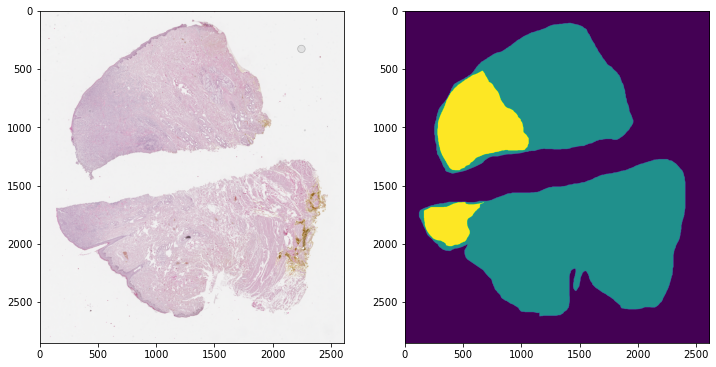

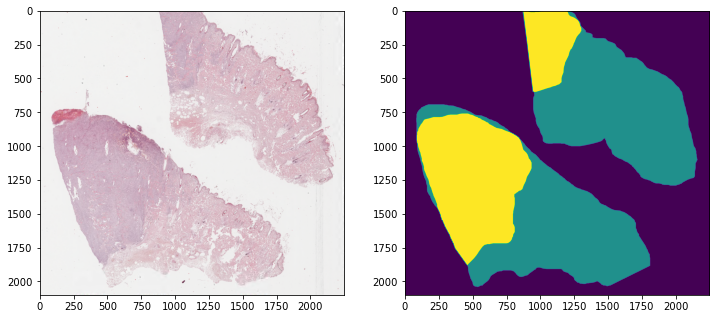

,image,vector,label,Path,PathBox,Type
0,1564,"{'x1': 0, 'y1': 0, 'x2': 512, 'y2': 512}",1,-726 Histiocytoma.svs,5707_14b_Histiocytoma_MF_0_0_512_512.svs,Background
1,1564,"{'x1': 0, 'y1': 512, 'x2': 512, 'y2': 1024}",1,-726 Histiocytoma.svs,5707_14b_Histiocytoma_MF_0_512_512_1024.svs,Background
2,1564,"{'x1': 0, 'y1': 1024, 'x2': 512, 'y2': 1536}",1,-726 Histiocytoma.svs,5707_14b_Histiocytoma_MF_0_1024_512_1536.svs,Background
3,1564,"{'x1': 0, 'y1': 1536, 'x2': 512, 'y2': 2048}",1,-726 Histiocytoma.svs,5707_14b_Histiocytoma_MF_0_1536_512_2048.svs,Background
4,1564,"{'x1': 0, 'y1': 2048, 'x2': 512, 'y2': 2560}",1,-726 Histiocytoma.svs,5707_14b_Histiocytoma_MF_0_2048_512_2560.svs,Background


In [18]:
patch_size = 512
tumor_id = 318
results = []
id_label_lookup = type_dict = {1: "Background", 2: "Tissue", 3: "Tumor"}


for image_id in annotations["Image"].unique():

    imageDF = annotations[annotations["Image"] == image_id]
    path =  list(imageDF["Path"].unique())[0]

    # open slide
    slide = OpenSlide(filename=str(path))
    level_dimensions = slide.level_dimensions[-1]
    down_levels = slide.level_downsamples[-1]
    level = slide.level_count - 1

    image = np.array(slide.read_region(location=(0, 0), level=level, size=level_dimensions))[:,:,:3]
    
    # set background
    mask = np.ones(shape=image.shape[:2])
    
    # set foreground
    for anno_vector in imageDF["Vector"]:
        
        vector = []
        for i in range(1, (len(anno_vector) // 2) + 1):
            vector.append([anno_vector['x' + str(i)], anno_vector['y' + str(i)]])
        poly = np.array(vector) / down_levels
        cv2.drawContours(mask, [poly.reshape((-1, 1, 2)).astype(int)], -1, 2, -1)
        
    # set tumor
    for anno_vector in imageDF[imageDF["Type"].isin([tumor_id])]["Vector"]:
        
        vector = []
        for i in range(1, (len(anno_vector) // 2) + 1):
            vector.append([anno_vector['x' + str(i)], anno_vector['y' + str(i)]])
        poly = np.array(vector) / down_levels
        cv2.drawContours(mask, [poly.reshape((-1, 1, 2)).astype(int)], -1, 3, -1)
    
    f, axarr = plt.subplots(1,2, figsize=(12, 12))
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    plt.show()
    
    down_levels = int(down_levels)
    patch_small = int(patch_size / down_levels)
    
    # divide into patches
    for x in range(0, level_dimensions[0] - patch_small, patch_small):
        for y in range(0, level_dimensions[1] - patch_small, patch_small):

            patch = mask[y:y+patch_small, x:x+patch_small].astype(int)

            # label to patch with most pixel for background, tissue or tumor
            pixel_counts = np.array([np.count_nonzero(patch[patch==1]), np.count_nonzero(patch[patch==2]), np.count_nonzero(patch[patch==3])])
            label = int(np.argmax(pixel_counts) + 1)

            x1_real = int(x * down_levels)
            y1_real = int(y * down_levels)

            x2_real = int(x1_real + patch_size)
            y2_real = int(y1_real + patch_size)

            vector = {"x1":x1_real, "y1":y1_real, "x2":x2_real, "y2":y2_real}
            
            temp_name = name.replace(".svs", "_{}_{}_{}_{}.svs".format(vector["x1"],vector["y1"],vector["x2"],vector["y2"]))
            results.append([image_id, vector, label, path.name, temp_name, id_label_lookup[label]])
            
labels = pd.DataFrame(results, columns=["image", "vector", "label", "Path", "PathBox","Type"])
labels.head() 

# Upload labels to EXACT

In [8]:
type_dict = {1: 315, 2: 316, 3: 317}


upload_list = []
for image_id, vector, label in zip(labels["image"], labels["vector"], labels["label"]):
    
    annotation_type = type_dict[label]
    
    body = Annotation(annotation_type=annotation_type, vector=vector, image=image_id)
    upload_list.append(body)

annotations_api.create_annotation(body=upload_list, async_req=True)

# Train classifier

In [9]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.data_block import *

In [10]:
bs = 32
samples = 32
path = Path('examples/images/') 

In [11]:
df = labels.copy()

In [13]:
slide_dict = {}

class SlideImageItemList(ImageList):
    def open(self, fn):
        "Open and load a `PIL.Image` and convert to `mode`"

        path = "_".join(str(fn).split("_")[:len(str(fn).split("_")) - 4]) + ".svs"
        
        if path not in slide_dict:
            slide = openslide.open_slide(path)
            slide_dict[path] = slide
        else:
            slide = slide_dict[path]
        

        x1, y1, x2, y2 = [int(v) for v in str(fn).replace(".svs","").split("_")[len(str(fn).split("_")) - 4:]]
        im = np.array(slide.read_region(location=(int(x1), int(y1)),
                                                level=0, size=(x2-x1, y2-y1))) / 255.

        return Image(pil2tensor(im[:,:,:3], np.float32))

In [14]:
tfms = get_transforms(flip_vert=True)

data = (SlideImageItemList.from_df(df, path, cols="PathBox")
        .split_by_rand_pct()
        #.split_by_valid_func(split_func)
        .label_from_df(cols='Type')
        .transform(tfms, size=256)
        .databunch(bs=bs, num_workers=0).normalize(imagenet_stats))

## Tumor, tissue and background patches

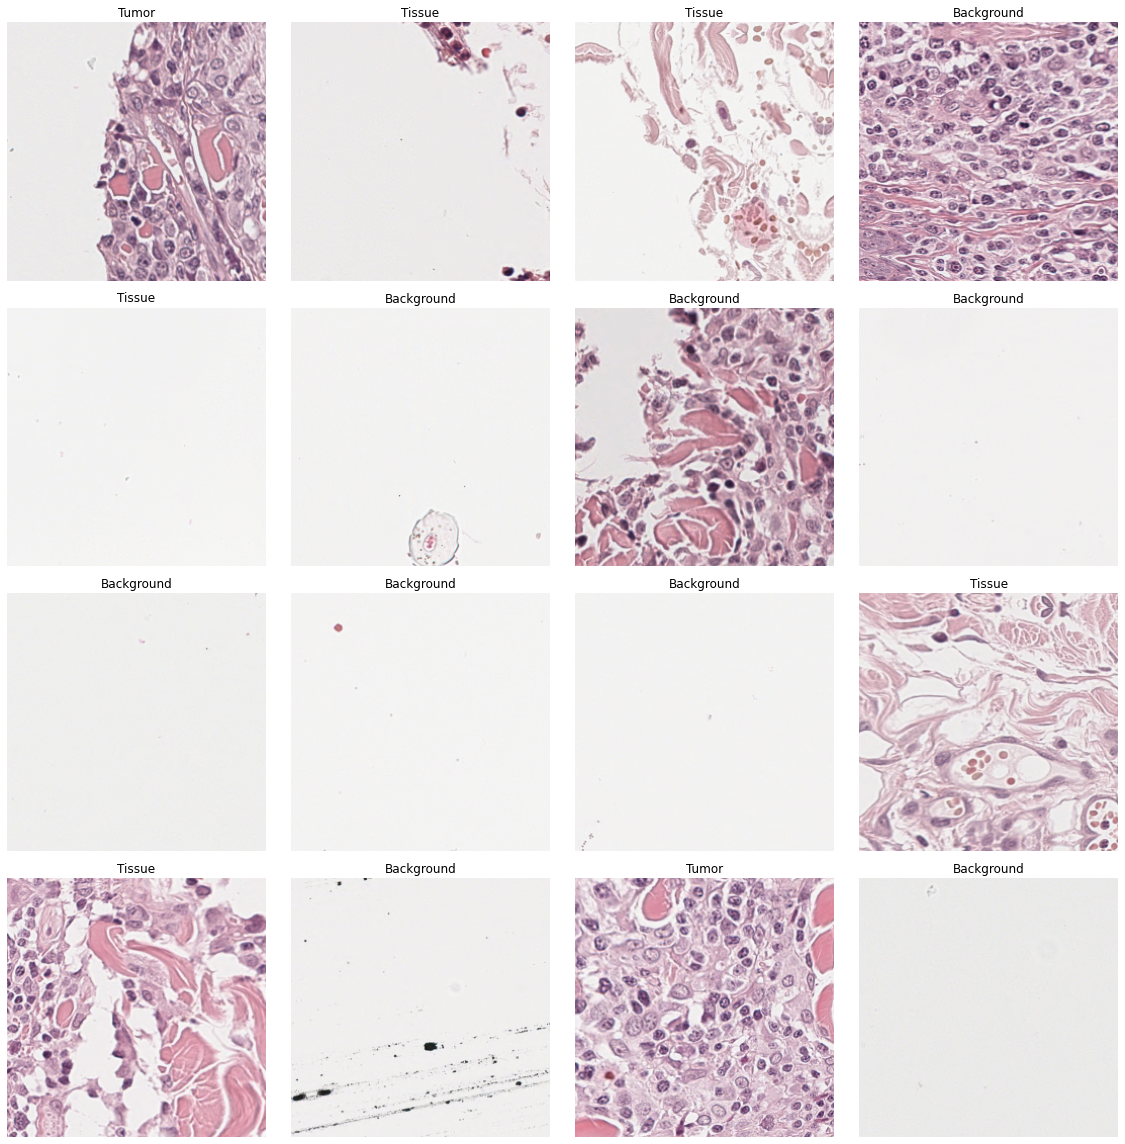

In [15]:
data.show_batch(rows=4, figsize=(16,16))

## ResNet-18 model

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy], callback_fns=[ShowGraph])

## Find good learning rate

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

## Train model

In [ ]:
learn.fit_one_cycle(10,1e-3)

In [ ]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()